In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.optimize import minimize
import time
from IPython.display import display, clear_output

# Functions and plots

In [2]:
def f1(x1 : float, y1 : float) -> float:
    return (x1**2 + y1 - 11)**2 + (x1 + y1**2 - 7)**2

In [3]:
def f2(x2 : float, y2 : float) -> float:
    return 2*x2**2 + 1.05*x2**4 + (x2**6)/6 + x2*y2 + y2**2

In [4]:
def f1_wrapper(x : np.ndarray) -> float:
    x1, y1 = x[0], x[1]
    return f1(x1, y1)

In [5]:
def f2_wrapper(x : np.ndarray) -> float:
    x2, y2 = x[0], x[1]
    return f2(x2, y2)

In [6]:
def find_minima_in_bounds(f_wrapper : callable, x_bounds : tuple, y_bounds : tuple, number_of_points = 100) -> list:
    x = np.linspace(x_bounds[0], x_bounds[1], int(np.sqrt(number_of_points)))
    y = np.linspace(y_bounds[0], y_bounds[1], int(np.sqrt(number_of_points)))
    linespace_grid = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    mins = []
    for point in linespace_grid:
        minimum = minimize(f_wrapper, point, bounds=[x_bounds, y_bounds])
        minimum = (round(minimum.x[0], 2), round(minimum.x[1], 2), round(minimum.fun, 2))
        mins.append(minimum)
    mins = set(mins)
    mins = sorted(mins, key=lambda x: x[2])
    return mins

In [7]:
def plot_function(function : callable, wrapper : callable, x_range : tuple, y_range : tuple, title : str, num_contours=50) -> None:
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = function(X, Y)

    fig = plt.figure(figsize=(15, 6))

    # Plot 3D
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8, antialiased=True, shade=True)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title(title)
    ax1.grid(True)

    # Contours (Top view)
    ax2 = fig.add_subplot(122)
    contour = ax2.contour(X, Y, Z, num_contours, cmap='viridis')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title(title + " - Contours (Top view)")

    # find all mins
    mins = find_minima_in_bounds(wrapper, x_range, y_range)
    if mins:
        global_min = mins[0]
        ax2.plot(global_min[0], global_min[1], 'r*', markersize=10, label=f"Global min (Z = {global_min[2]})")
        local_mins = mins[1:]
        for local_min in local_mins:
            ax2.plot(local_min[0], local_min[1], 'g*', markersize=10, label=f"Local min (Z = {local_min[2]})")

    ax2.legend()

    plt.tight_layout()
    plt.show()

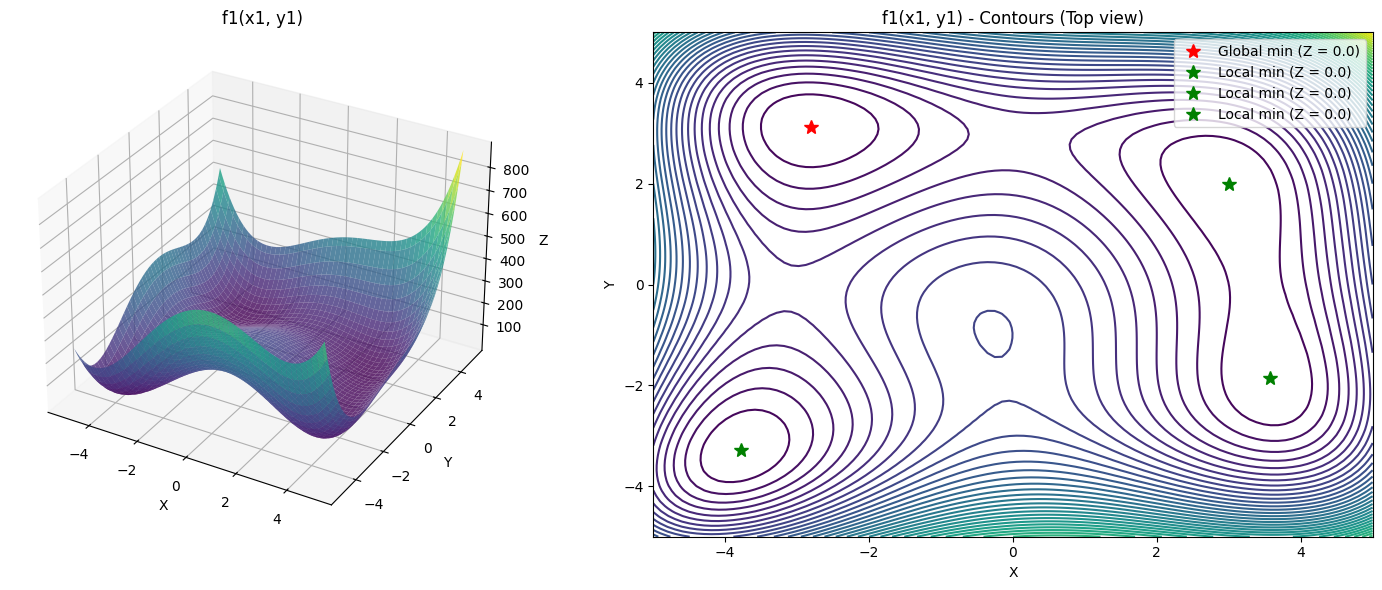

In [8]:
plot_function(f1, f1_wrapper, (-5, 5), (-5, 5), 'f1(x1, y1)')

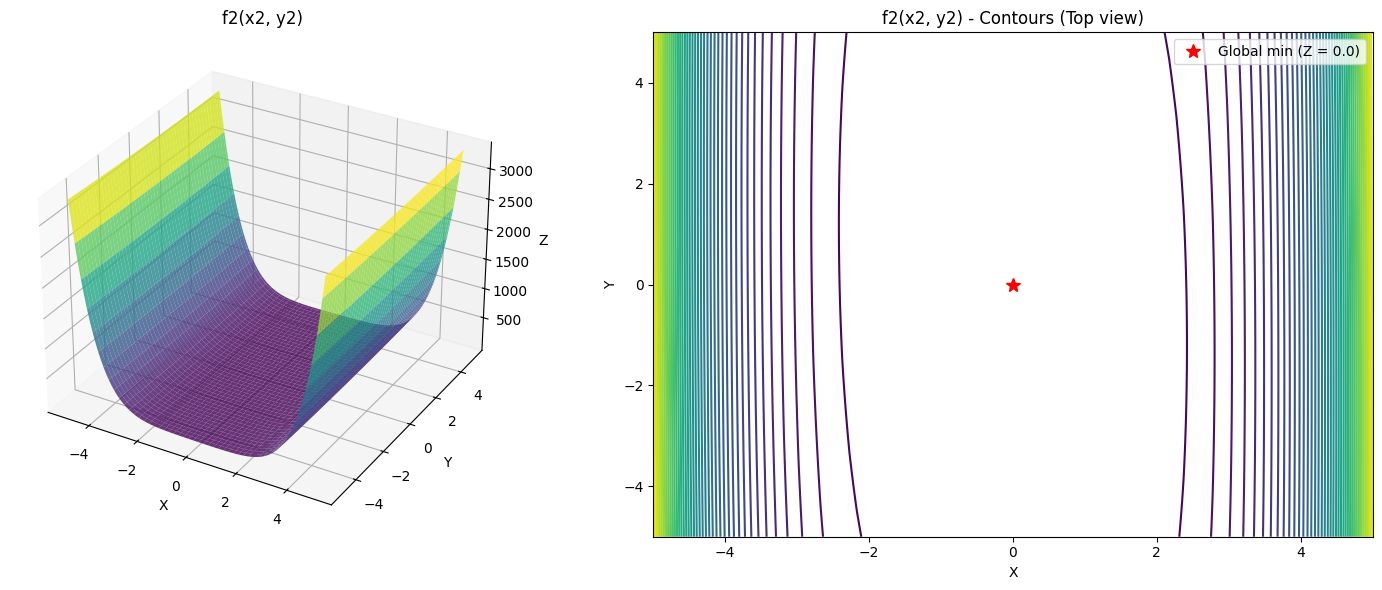

In [9]:
plot_function(f2, f2_wrapper, (-5, 5), (-5, 5), 'f2(x2, y2)')

# Implementation of evolutionary algorithm

In [10]:
class Entity:
    def __init__(self, f_range : tuple, is_normal_dist = False) -> None:
        self.result = None
        self.chromosome = np.zeros(4)

        if is_normal_dist:
            self.initialize_normal_dist_chromosome(f_range)
        else:
            self.initialize_random_chromosome(f_range)

    def get_chromosome(self) -> np.ndarray:
        return self.chromosome

    def get_result(self) -> float:
        return self.result

    def initialize_random_chromosome(self, f_range : tuple) -> None:
        self.chromosome[0] = np.random.uniform(f_range[0], f_range[1])
        self.chromosome[1] = np.random.uniform(f_range[0], f_range[1])
        self.chromosome[2] = np.random.uniform(f_range[0], f_range[1])
        self.chromosome[3] = np.random.uniform(f_range[0], f_range[1])

    def initialize_normal_dist_chromosome(self, f_range : tuple) -> None:
        x_mean, y_mean = -0.3, -0.9
        x_stddev, y_stddev = 0.1, 0.1
        self.chromosome[0] = np.random.normal(x_mean, x_stddev)
        self.chromosome[1] = np.random.normal(y_mean, y_stddev)
        self.chromosome[2] = np.random.normal(f_range[0], f_range[1])
        self.chromosome[3] = np.random.normal(f_range[0], f_range[1])

    def set_chromosome_values(self, x1 : float, y1 : float, x2 : float, y2 : float) -> None:
        self.chromosome[0] = x1
        self.chromosome[1] = y1
        self.chromosome[2] = x2
        self.chromosome[3] = y2

    def set_result(self, result : float) -> None:
        self.result = result

    def mutate_cell(self, index : int, mutation : float) -> None:
        self.chromosome[index] += mutation

    def __str__(self) -> str:
        return f"Entity: {self.chromosome}, Fitness: {self.result}"

In [11]:
class Population:
    def __init__(self, f_range : tuple, population_size : int, is_normal_dist : bool) -> None:
        self.population_size = population_size
        self.entities = []
        self.best_entity = None
        self.function_range = f_range
        self.initialize_population(is_normal_dist)

    def initialize_population(self, is_normal_dist) -> None:
        for _ in range(self.population_size):
            self.entities.append(Entity(self.function_range, is_normal_dist))

    def evaluate_population(self, penalty : int) -> None:
        for entity in self.entities:
            entity.set_result(fitness_function(entity, self.function_range, penalty))
        self.entities = sorted(self.entities, key=lambda entity: entity.result)

    def find_best_entity(self) -> None:
        self.best_entity = min(self.entities, key=lambda entity: entity.result)

    def __str__(self) -> str:
        result = ""
        for entity in self.entities:
            result += str(entity) + "\n"
        return result

In [12]:
def fitness_function(entity : Entity, f_range : tuple, penalty : int) -> float:
    x1, y1, x2, y2 = entity.get_chromosome()
    result = f1(x1, y1) + f2(x2, y2)
    out_of_bounds = sum([x1 < f_range[0], x1 > f_range[1], y1 < f_range[0], y1 > f_range[1], x2 < f_range[0], x2 > f_range[1], y2 < f_range[0], y2 > f_range[1]])
    for _ in range(out_of_bounds):
        result += penalty
    return result

In [13]:
class EvolutionaryAlgorithm:
    def __init__(self,
                 fitness_function : callable,
                 population : Population,
                 max_time : int,
                 penalty : int,
                 mutation_rate : float,
                 mutation_range : float,
                 crossover_rate : float):

        self.fitness_function = fitness_function
        self.population = population
        self.max_time = max(max_time, 0)
        self.start_time = self.max_time
        self.penalty = penalty
        self.mutation_rate = mutation_rate
        self.mutation_range = mutation_range
        self.crossover_rate = crossover_rate
        self.best_entity = None

    def tournament_selection(self):
        new_generation = []
        for entity in self.population.entities:
            opponent = np.random.choice(self.population.entities)
            if entity.get_result() < opponent.get_result():
                new_generation.append(entity)
            else:
                new_generation.append(opponent)
        self.population.entities = new_generation

    def gaussian_mutation(self):
        for entity in self.population.entities:
            for i in range(len(entity.get_chromosome())):
                if np.random.uniform(0, 1) < self.mutation_rate:
                    entity.mutate_cell(i, np.random.normal(-self.mutation_range, self.mutation_range))

    def crossover(self):
        new_generation = []
        for entity in self.population.entities:
            if np.random.uniform(0, 1) < self.crossover_rate:
                partner = np.random.choice(self.population.entities)
                crossover_point = np.random.randint(0, len(entity.get_chromosome()))
                child = Entity(self.population.function_range)
                child_chromosome = list(entity.get_chromosome())[:crossover_point] + list(partner.get_chromosome())[crossover_point:]
                child.set_chromosome_values(*child_chromosome)
                new_generation.append(child)
            else:
                new_generation.append(entity)
        self.population.entities = new_generation


    def run_algorithm(self, visualize = False):
        self.population.evaluate_population(self.penalty)
        self.population.find_best_entity()
        self.best_entity = self.population.best_entity
        while self.max_time > 0:
            self.tournament_selection()
            self.gaussian_mutation()
            self.crossover()
            self.population.evaluate_population(self.penalty)
            self.population.find_best_entity()
            if self.population.best_entity.get_result() < self.best_entity.get_result():
                self.best_entity = self.population.best_entity
            self.max_time -= 1
            if visualize:
                visualize_algorithm(self.population, self.max_time, self.start_time)
        return self.best_entity

# Algorithm visulaization

In [14]:
def get_graph_background():
    # Tworzenie siatki danych
    x = np.linspace(-9, 9, 100)
    y = np.linspace(-9, 9, 100)
    X, Y = np.meshgrid(x, y)

    # Obliczanie wartości funkcji f1 i f2 na danej siatce
    Z1 = f1(X, Y)
    Z2 = f2(X, Y)

    # Tworzenie nowego wykresu
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

    # Wykres f1(x, y) - z kolorami
    contour1 = ax1.contour(X, Y, Z1, 60, cmap='viridis')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title('f1(x, y) - Colored Contours (Top view)')

    # Wykres f2(x, y) - z kolorami
    contour2 = ax2.contour(X, Y, Z2, 60, cmap='viridis')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('f2(x, y) - Colored Contours (Top view)')

    # Dodawanie punktów minimalnych do obu wykresów
    mins1 = find_minima_in_bounds(f1_wrapper, (-5, 5), (-5, 5))
    if mins1:
        global_min1 = mins1[0]
        ax1.plot(global_min1[0], global_min1[1], 'r*', markersize=10, label=f"Global min (Z = {global_min1[2]})")
        local_mins1 = mins1[1:]
        for local_min1 in local_mins1:
            ax1.plot(local_min1[0], local_min1[1], 'g*', markersize=10, label=f"Local min (Z = {local_min1[2]}")

    mins2 = find_minima_in_bounds(f2_wrapper, (-5, 5), (-5, 5))
    if mins2:
        global_min2 = mins2[0]
        ax2.plot(global_min2[0], global_min2[1], 'r*', markersize=10, label=f"Global min (Z = {global_min2[2]})")
        local_mins2 = mins2[1:]
        for local_min2 in local_mins2:
            ax2.plot(local_min2[0], local_min2[1], 'g*', markersize=10, label=f"Local min (Z = {local_min2[2]}")

    # Legenda na obu wykresach
    ax1.legend()
    ax2.legend()

    plt.tight_layout()
    return (plt, ax1, ax2)


In [15]:
def visualize_algorithm(population, current_time, max_time):
    sleep_time = 0.01
    my_plt, ax1, ax2 = get_graph_background()
    x1 = [entity.get_chromosome()[0] for entity in population.entities]
    y1 = [entity.get_chromosome()[1] for entity in population.entities]
    x2 = [entity.get_chromosome()[2] for entity in population.entities]
    y2 = [entity.get_chromosome()[3] for entity in population.entities]
    generation_number = max_time - current_time

    # Wykres f1(x, y) - z kolorami
    ax1.scatter(x1, y1, marker='o', s=30, c='b', label=f'Generation {generation_number}')

    # Wykres f2(x, y) - z kolorami
    ax2.scatter(x2, y2, marker='o', s=30, c='b', label=f'Generation {generation_number}')

    ax1.legend()
    ax2.legend()

    display(my_plt.gcf())
    time.sleep(sleep_time)
    clear_output(wait=True)
    my_plt.close()


In [16]:
is_normal_dist = False
visualize = False
max_time = 1000
penalty = 10000
mutation_rate = 0.1
mutation_range = 3
crossover_rate = 0.7
population_size = 60
start_population = Population((-5, 5), population_size, is_normal_dist)

algorthm = EvolutionaryAlgorithm(fitness_function, start_population, max_time, penalty, mutation_rate, mutation_range, crossover_rate)
best_entity = algorthm.run_algorithm(visualize)

print("Best Entity:")
print(best_entity)
print("Final population:")
print(algorthm.population)

Best Entity:
Entity: [ -3.67956234 -10.08560499  -0.33106285   1.34132372], Fitness: 2.1138544276952933
Final population:
Entity: [-4.13671531 -3.55524197 -1.39669738 -2.97865675], Fitness: 30.965448639702313
Entity: [-4.54355827 -0.67807523 -4.07930905 -2.97865675], Fitness: 1316.3146152787265
Entity: [-2.01957692 -1.96857796 -2.28248957 -6.77592552], Fitness: 10229.357863582894
Entity: [-2.01957692 -1.96857796 -2.28248957 -6.77592552], Fitness: 10229.357863582894
Entity: [ -4.3196807   -4.03510222  -1.39669738 -14.46563644], Fitness: 10276.355691209223
Entity: [ -4.3196807   -0.67807523  -1.39669738 -11.28331562], Fitness: 10318.886711972831
Entity: [ -4.13671531  -3.55524197  -1.39669738 -22.36784805], Fitness: 10549.494511813886
Entity: [ -4.13671531  -3.55524197  -1.39669738 -22.69405269], Fitness: 10564.64952204795
Entity: [ -4.3196807    0.79050372  -1.39669738 -19.29435366], Fitness: 10594.138370189186
Entity: [ -4.54355827  -1.96857796  -2.28248957 -21.71032594], Fitness: 1070

# Tests

In [17]:
import ipytest
import pytest
ipytest.autoconfig()

In [18]:
@pytest.fixture
def mock_np_random_uniform(monkeypatch):

    def mock_uniform(low, high):
        return 0.5

    monkeypatch.setattr(np.random, 'uniform', mock_uniform)

def test_initialize_random_chromosome(mock_np_random_uniform):
    f_range = (0, 1)
    entity = Entity(f_range)
    assert entity.chromosome[0] == 0.5
    assert entity.chromosome[1] == 0.5
    assert entity.chromosome[2] == 0.5
    assert entity.chromosome[3] == 0.5

def test_set_chromosome_values():
    entity = Entity((0, 1))
    entity.set_chromosome_values(1.0, 2.0, 3.0, 4.0)
    assert entity.chromosome[0] == 1.0
    assert entity.chromosome[1] == 2.0
    assert entity.chromosome[2] == 3.0
    assert entity.chromosome[3] == 4.0

def test_str_representation():
    entity = Entity((0, 1))
    entity.set_chromosome_values(1.0, 2.0, 3.0, 4.0)
    entity.result = 42.0
    assert str(entity) == "Entity: [1. 2. 3. 4.], Fitness: 42.0"

def test_fitness_function():
    entity = Entity((0, 1))
    entity.set_chromosome_values(0.5, 0.5, 0.7, 0.7)
    f_range = (0, 1)
    penalty = 10.0
    expected_result = f1(0.5, 0.5) + f2(0.7, 0.7)
    result = fitness_function(entity, f_range, penalty)
    assert result == expected_result

def test_fitness_function_penalty():
    entity = Entity((0, 1))
    entity.set_chromosome_values(1.5, 0.5, 0.7, 0.7)
    f_range = (0, 1)
    penalty = 10.0
    expected_result = f1(1.5, 0.5) + f2(0.7, 0.7) + penalty
    result = fitness_function(entity, f_range, penalty)
    assert result == expected_result

def test_initialize_population(mock_np_random_uniform):
    f_range = (0, 1)
    population_size = 10
    population = Population(f_range, population_size, False)
    assert len(population.entities) == population_size

def test_evaluate_population(mock_np_random_uniform):
    f_range = (0, 1)
    population_size = 5
    population = Population(f_range, population_size, False)
    penalty = 10.0
    population.evaluate_population(penalty)
    for entity in population.entities:
        assert entity.result is not None

def test_find_best_entity(mock_np_random_uniform):
    f_range = (0, 1)
    population_size = 5
    population = Population(f_range, population_size, False)
    penalty = 10.0
    population.evaluate_population(penalty)
    population.find_best_entity()
    assert population.best_entity == min(population.entities, key=lambda entity: entity.result)

ipytest.run()

........                                                                                     [100%]
8 passed in 0.02s


<ExitCode.OK: 0>